This notebook was created as a part of my ML course I took as a way to learn to implement data preprocessing and model evaluation.

I used this notebook by https://www.kaggle.com/ludovicocuoghi as a guide.

https://www.kaggle.com/code/ludovicocuoghi/xgboost-optuna-deep-feature-engineering-r2-93

# Laptop Price Prediction Model

Importing necessary modules and packages.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/laptop-price/laptop_price.csv


In [3]:
df = pd.read_csv('/kaggle/input/laptop-price/laptop_price.csv', encoding="ISO-8859-1")

In [4]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [6]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


## 1. Data Cleaning & Preprocessing

In [7]:
df = df.rename(columns=str.lower)

In [8]:
df.columns

Index(['laptop_id', 'company', 'product', 'typename', 'inches',
       'screenresolution', 'cpu', 'ram', 'memory', 'gpu', 'opsys', 'weight',
       'price_euros'],
      dtype='object')

In [9]:
df = df.rename(columns={'price_euros':'price'})

#### Checking Duplicates

In [10]:
df[df.duplicated()]

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price


### Feature Engineering + Regular Expression

In [11]:
import regex as re

#### Laptop ID

In [12]:
df['laptop_id']

0          1
1          2
2          3
3          4
4          5
        ... 
1298    1316
1299    1317
1300    1318
1301    1319
1302    1320
Name: laptop_id, Length: 1303, dtype: int64

In [13]:
df=df.drop('laptop_id', axis=1)

We dropped the laptop_id column since we don't need it.

#### Screen Resolution

In [14]:
df['screenresolution']

0               IPS Panel Retina Display 2560x1600
1                                         1440x900
2                                Full HD 1920x1080
3               IPS Panel Retina Display 2880x1800
4               IPS Panel Retina Display 2560x1600
                           ...                    
1298     IPS Panel Full HD / Touchscreen 1920x1080
1299    IPS Panel Quad HD+ / Touchscreen 3200x1800
1300                                      1366x768
1301                                      1366x768
1302                                      1366x768
Name: screenresolution, Length: 1303, dtype: object

In the screen resolution column, there are multiple useful informations which can't be read properly yet.

So we will separate this 3 informations **(Screen type, Resolution, Touchscreen)** in 3 different columns using regular expression.

In [15]:
df['resolution'] = df['screenresolution'].str.extract(r'(\d+x\d+)')

In [16]:
df['screentype'] = df['screenresolution'].replace(r'(\d+x\d+)','',regex=True)

In [17]:
df['screentype'] = df['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','',regex=True)

In [18]:
df['screentype']

0       IPS Panel Retina Display 
1                                
2                                
3       IPS Panel Retina Display 
4       IPS Panel Retina Display 
                  ...            
1298     IPS Panel   Touchscreen 
1299     IPS Panel   Touchscreen 
1300                             
1301                             
1302                             
Name: screentype, Length: 1303, dtype: object

In [19]:
df['touchscreen'] = df['screentype'].str.extract(r'(Touchscreen)')
df['screentype'] = df['screentype'].replace(r'(Touchscreen)','',regex=True)

In [20]:
df['touchscreen'].value_counts()

Touchscreen    192
Name: touchscreen, dtype: int64

*One hot encoding for presence or absence of Touchscreen feature.*

In [21]:
df['touchscreen'] = df['touchscreen'].replace('Touchscreen',1)
df['touchscreen'] = df['touchscreen'].replace(np.nan,0)

In [22]:
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

In [23]:
df['screentype'].value_counts()

                             549
                             314
IPS Panel                    265
                              75
IPS Panel                     72
IPS Panel Retina Display      17
IPS Panel                     11
Name: screentype, dtype: int64

In [24]:
df['screentype']=df['screentype'].replace(r' ','',regex=True)
df['screentype'].value_counts()

                         938
IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

Replacing blank spaces with NaN.

In [25]:
df['screentype'] = df['screentype'].replace(r'^\s*$', np.nan, regex=True)
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

In [26]:
df.head()

,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0


*Removing the Screen Resolution column as we extracted all the necessary information from it.*

In [27]:
df = df.drop('screenresolution', axis=1)

In [28]:
df.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0


In [29]:
df['resolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: resolution, dtype: int64

In [30]:
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

In [31]:
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

In [32]:
df['cpu']

0                       Intel Core i5 2.3GHz
1                       Intel Core i5 1.8GHz
2                 Intel Core i5 7200U 2.5GHz
3                       Intel Core i7 2.7GHz
4                       Intel Core i5 3.1GHz
                        ...                 
1298              Intel Core i7 6500U 2.5GHz
1299              Intel Core i7 6500U 2.5GHz
1300    Intel Celeron Dual Core N3050 1.6GHz
1301              Intel Core i7 6500U 2.5GHz
1302    Intel Celeron Dual Core N3050 1.6GHz
Name: cpu, Length: 1303, dtype: object

*We are separating CPU info with CPU frequency using regex again.*

In [33]:
df['cpu_freq'] = df['cpu'].str.extract(r'(\d+(?:\.\d+)?GHz)') 

In [34]:
df['cpu_freq'].value_counts()

2.5GHz     290
2.7GHz     165
2.8GHz     165
1.6GHz     133
2.3GHz      86
1.8GHz      78
2.6GHz      76
2GHz        67
1.1GHz      53
2.4GHz      52
2.9GHz      21
3GHz        19
2.0GHz      19
1.2GHz      15
1.44GHz     12
2.2GHz      11
1.5GHz      10
1.3GHz       6
3.6GHz       5
0.9GHz       4
3.1GHz       3
2.1GHz       3
2.50GHz      3
1.9GHz       2
1.60GHz      1
3.2GHz       1
1.0GHz       1
1.92GHz      1
2.70GHz      1
Name: cpu_freq, dtype: int64

In [35]:
df['cpu_freq'] = df['cpu_freq'].str.replace('GHz', '')
df.rename(columns={'cpu_freq': 'cpu_freq(GHz)'}, inplace=True)

In [36]:
df['cpu_freq(GHz)'] = df['cpu_freq(GHz)'].astype(float)

In [37]:
df['cpu']= df['cpu'].str.replace(r'(\d+(?:\.\d+)?GHz)', '', regex=True)

In [38]:
df.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz)
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1


*We removed "GB" from each row in RAM column and added it into the column name and turned the column into Integer. This way we can perform numeric calculations on the row.*

In [39]:
df['ram'] = df['ram'].str.replace('GB', '')

In [40]:
df.rename(columns={'ram': 'ram(GB)'}, inplace=True)

In [41]:
df['ram(GB)'] = df['ram(GB)'].astype(int)

In [42]:
df.head()

,company,product,typename,inches,cpu,ram(GB),memory,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz)
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1


In [43]:
df['memory']

0                 128GB SSD
1       128GB Flash Storage
2                 256GB SSD
3                 512GB SSD
4                 256GB SSD
               ...         
1298              128GB SSD
1299              512GB SSD
1300     64GB Flash Storage
1301                1TB HDD
1302              500GB HDD
Name: memory, Length: 1303, dtype: object

In [44]:
df['memory'].value_counts()

256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

We can see that some laptops have 2 hard drives, there are 4 differnt types of disks: 'SSD', ''HDD', 'Hybrid' and 'Flash Storage'. We will create new columns to include all these information.

In [45]:
df['memory_1']=df['memory']

Converting all sizes into GB for uniformity.

In [46]:
df['memory_1']=df['memory_1'].str.replace('1.0TB','1TB', regex=True)
df['memory_1']=df['memory_1'].str.replace('1TB','1000GB')
df['memory_1']=df['memory_1'].str.replace('2TB','2000GB')
df['memory_1']=df['memory_1'].str.replace('GB','')
df['memory_1'].value_counts()

256 SSD                         412
1000 HDD                        224
500 HDD                         132
512 SSD                         118
128 SSD +  1000 HDD              94
128 SSD                          76
256 SSD +  1000 HDD              73
32 Flash Storage                 38
2000 HDD                         16
64 Flash Storage                 15
512 SSD +  1000 HDD              14
1000 SSD                         14
256 SSD +  2000 HDD              10
1000 Hybrid                       9
256 Flash Storage                 8
16 Flash Storage                  7
32 SSD                            6
180 SSD                           5
128 Flash Storage                 4
512 SSD +  2000 HDD               3
16 SSD                            3
512 Flash Storage                 2
1000 SSD +  1000 HDD              2
256 SSD +  500 HDD                2
128 SSD +  2000 HDD               2
256 SSD +  256 SSD                2
512 SSD +  256 SSD                1
512 SSD +  512 SSD          

In [47]:
df['memory2']=df['memory_1'].str.replace(r' ','')
df['memory2'].value_counts()

256SSD                    412
1000HDD                   224
500HDD                    132
512SSD                    118
128SSD+1000HDD             94
128SSD                     76
256SSD+1000HDD             73
32FlashStorage             38
2000HDD                    16
64FlashStorage             15
512SSD+1000HDD             14
1000SSD                    14
256SSD+2000HDD             10
1000Hybrid                  9
256FlashStorage             8
16FlashStorage              7
32SSD                       6
180SSD                      5
128FlashStorage             4
512SSD+2000HDD              3
16SSD                       3
512FlashStorage             2
1000SSD+1000HDD             2
256SSD+500HDD               2
128SSD+2000HDD              2
256SSD+256SSD               2
512SSD+256SSD               1
512SSD+512SSD               1
64FlashStorage+1000HDD      1
1000HDD+1000HDD             1
32HDD                       1
64SSD                       1
128HDD                      1
240SSD    

In [48]:
memory_1=[]
memory_2=[]
for i in df['memory2']:
    if len(re.findall(r'\+',i))==1: # DOUBLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append(one[1])
    else: # SINGLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append('NaN')

Now we have separated the drives into two lists. We will now create two more lists that will contain the memory types.

In [49]:
memory_1_gb=[]
memory_1_type=[]
for i in memory_1:
    memory_1_type.append(re.findall(r'(\D\w+)',i)[0])
    memory_1_gb.append(re.findall(r'(\d+)',i)[0])

We created succesfully two lists for memory_1 in order to include the capacity and type for each memory 1

In [50]:
memory_2_gb=[]
memory_2_type=[]
for i in memory_2:
    if i != 'NaN':
        memory_2_type.append(re.findall(r'(\D\w+)',i)[0])
        memory_2_gb.append(re.findall(r'(\d+)',i)[0])
    else:
        memory_2_type.append('NaN')
        memory_2_gb.append(0)

We created the same two lists that will contain type and capacity also for the second drive

In [51]:
df['memory_1_sto(GB)'] = memory_1_gb
df['memory_1_type'] = memory_1_type
df['memory_2_sto(GB)'] = memory_2_gb
df['memory_2_type'] = memory_2_type

Then we convert the capacity related columns to floats.

In [52]:
df['memory_1_sto(GB)'] = df['memory_1_sto(GB)'].astype(float)
df['memory_2_sto(GB)'] = df['memory_2_sto(GB)'].astype(float)

In [53]:
df.head()

,company,product,typename,inches,cpu,ram(GB),memory,gpu,opsys,weight,...,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1,memory2,memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128 SSD,128SSD,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,1440x900,NaN,0.0,1.8,128 Flash Storage,128FlashStorage,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,...,1920x1080,NaN,0.0,2.5,256 SSD,256SSD,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512 SSD,512SSD,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256 SSD,256SSD,256.0,SSD,0.0,NaN


In [54]:
df=df.drop(['memory_1','memory2','memory'], axis=1)

In [55]:
df = df.replace({'NaN': np.nan})

In [56]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


In [57]:
df['weight'].value_counts()

2.2kg     121
2.1kg      58
2.4kg      44
2.3kg      41
2.5kg      38
         ... 
3.25kg      1
4.7kg       1
1.55kg      1
1.18kg      1
4.0kg       1
Name: weight, Length: 179, dtype: int64

Checking is all rows have a weight specified in kg.

In [58]:
df['weight'].str.contains('kg').sum()

1303

All rows returned true. That means all rows are in kg.

In [59]:
df['weight'] = df['weight'].str.replace('kg','').astype(float)

In [60]:
df.rename(columns={'weight': 'weight(kg)'}, inplace=True)

In [61]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


In [62]:
df['cpu_brand'] = df['cpu'].str.extract(r'^(\w+)')
df['cpu_brand'].value_counts()

Intel      1240
AMD          62
Samsung       1
Name: cpu_brand, dtype: int64

In [63]:
df[df['cpu_brand']=='Samsung']

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand
1191,Samsung,Chromebook Plus,2 in 1 Convertible,12.3,Samsung Cortex A72&A53,4,ARM Mali T860 MP4,Chrome OS,1.15,659.0,2400x1600,IPSPanel,1.0,2.0,32.0,FlashStorage,0.0,NaN,Samsung


Since this is the only entry containing a Samsung CPU and ARM GPU, we are dropping this row as to simplify the comparison among others.

In [64]:
df=df.drop(1191)

In [65]:
df['gpu_brand'] = df['gpu'].str.extract(r'^(\w+)')
df['gpu_brand'].value_counts()

Intel     722
Nvidia    400
AMD       180
Name: gpu_brand, dtype: int64

In [66]:
df[df['gpu_brand']=='ARM']

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand


In [67]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1302 non-null   object 
 1   product           1302 non-null   object 
 2   typename          1302 non-null   object 
 3   inches            1302 non-null   float64
 4   cpu               1302 non-null   object 
 5   ram(GB)           1302 non-null   int64  
 6   gpu               1302 non-null   object 
 7   opsys             1302 non-null   object 
 8   weight(kg)        1302 non-null   float64
 9   price             1302 non-null   float64
 10  resolution        1302 non-null   object 
 11  screentype        364 non-null    object 
 12  touchscreen       1302 non-null   float64
 13  cpu_freq(GHz)     1302 non-null   float64
 14  memory_1_sto(GB)  1302 non-null   float64
 15  memory_1_type     1302 non-null   object 
 16  memory_2_sto(GB)  1302 non-null   float64


In [69]:
df.to_csv('laptop-clean.csv', index=False)
print('Cleaned dataset exported to CSV.')

Cleaned dataset exported to CSV.


## 2. Exploratory Data Analysis (EDA)

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [71]:
df1=pd.read_csv('laptop-clean.csv')
df1.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


We will futher clean the data frame to remove outliers.

In [72]:
df_clean=df1.copy()

In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1302 non-null   object 
 1   product           1302 non-null   object 
 2   typename          1302 non-null   object 
 3   inches            1302 non-null   float64
 4   cpu               1302 non-null   object 
 5   ram(GB)           1302 non-null   int64  
 6   gpu               1302 non-null   object 
 7   opsys             1302 non-null   object 
 8   weight(kg)        1302 non-null   float64
 9   price             1302 non-null   float64
 10  resolution        1302 non-null   object 
 11  screentype        364 non-null    object 
 12  touchscreen       1302 non-null   float64
 13  cpu_freq(GHz)     1302 non-null   float64
 14  memory_1_sto(GB)  1302 non-null   float64
 15  memory_1_type     1302 non-null   object 
 16  memory_2_sto(GB)  1302 non-null   float64


### Most frequent in brand the dataframe

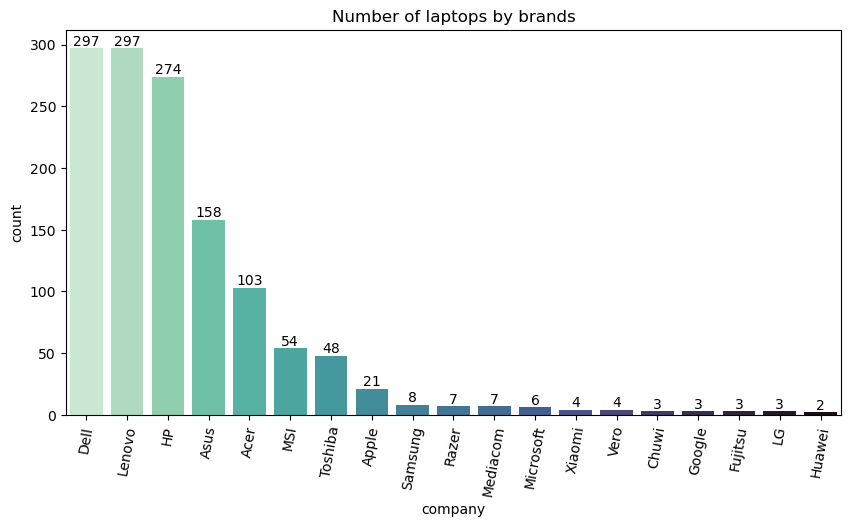

In [74]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='company', data=df, palette='mako_r', order = df['company'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
ax.bar_label(ax.containers[0])
plt.title('Number of laptops by brands')
plt.show()

### Most frequent in Laptop the dataframe

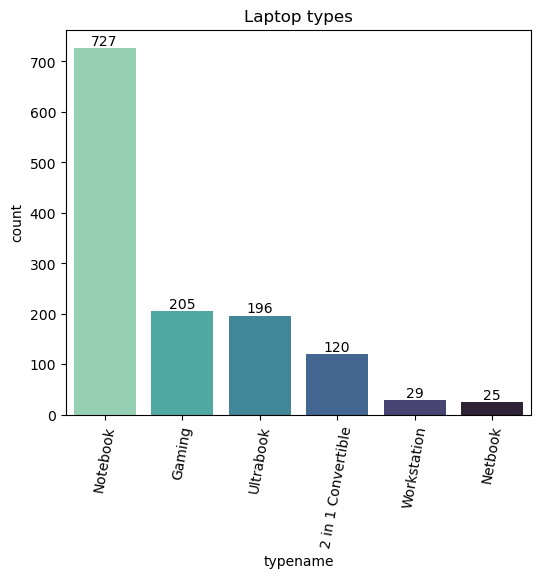

In [75]:
fig, ax  = plt.subplots(figsize=(6,5))
ax=sns.countplot(x='typename', data=df,palette='mako_r', order = df['typename'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Laptop types')
plt.show()

In [76]:
notebook_percentage = '{:.2f}'.format(len(df[df['typename']=='Notebook'])*100/len(df))
print('Most laptops are notebooks, which make ' +notebook_percentage+ '% of the total laptops.')

Most laptops are notebooks, which make 55.84% of the total laptops.


### Most popular screen size

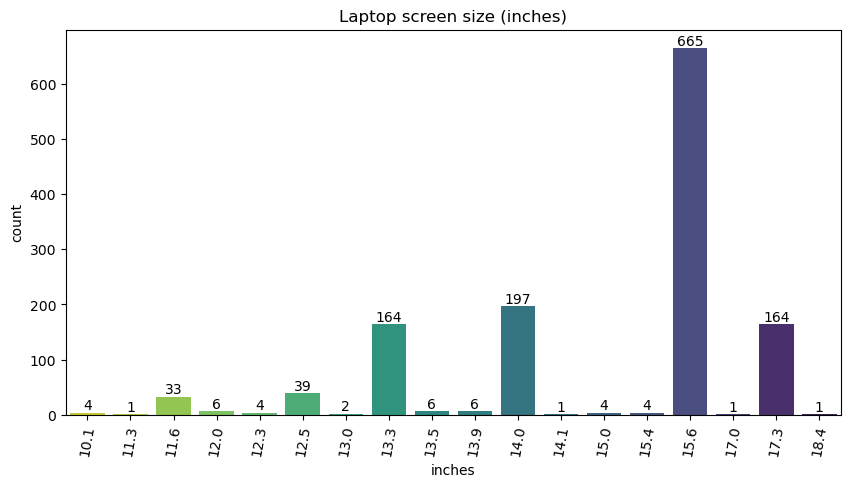

In [77]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='inches', data=df, palette='viridis_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')
plt.show()

In [78]:
popular_size_percentage = '{:.2f}'.format(len(df[df['inches']==15.6])*100/len(df))
print('Most laptops have 15.6 inches screen size, which make ' +popular_size_percentage+ '% of the total laptops.')

Most laptops have 15.6 inches screen size, which make 51.08% of the total laptops.


Since there are a few laptops with non conventional sizes, we will only keep laptops with the conventional sizes.

In [79]:
inches_list = df['inches'].value_counts().index[:6].tolist()
inches_list

[15.6, 14.0, 13.3, 17.3, 12.5, 11.6]

In [80]:
df_clean = df_clean[df_clean['inches'].isin(inches_list)]

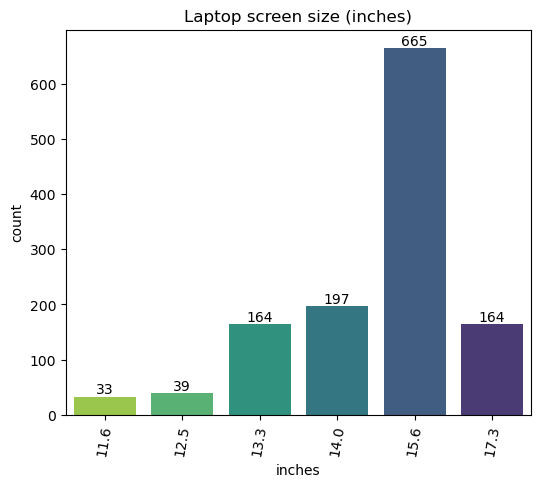

In [81]:
fig, ax  = plt.subplots(figsize=(6,5))
ax=sns.countplot(x='inches', data=df_clean, palette='viridis_r')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Laptop screen size (inches)')
plt.show()

### Weight distribution among laptops

In [82]:
# Writing a custom function to improve plot readability
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0])
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1])
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linewidth=2.2, label='mode='+ str(df[col].mode()[0]) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

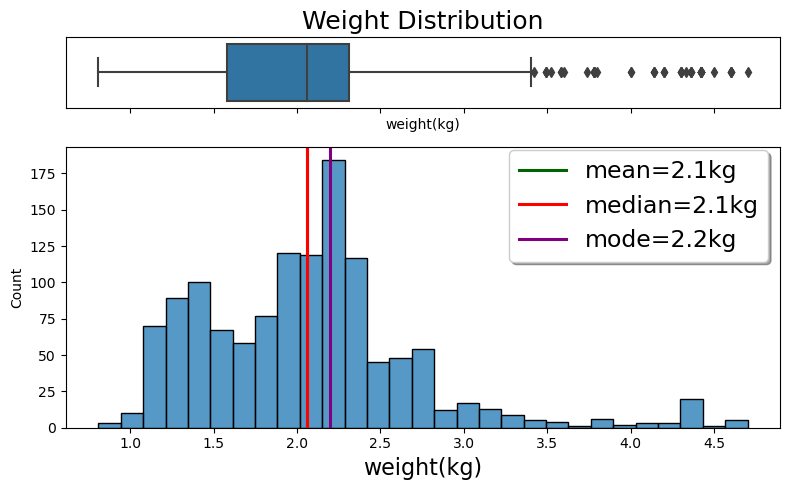

In [83]:
num_plot(df_clean, 'weight(kg)', 'Weight Distribution','kg')

### Price distribution among the laptops

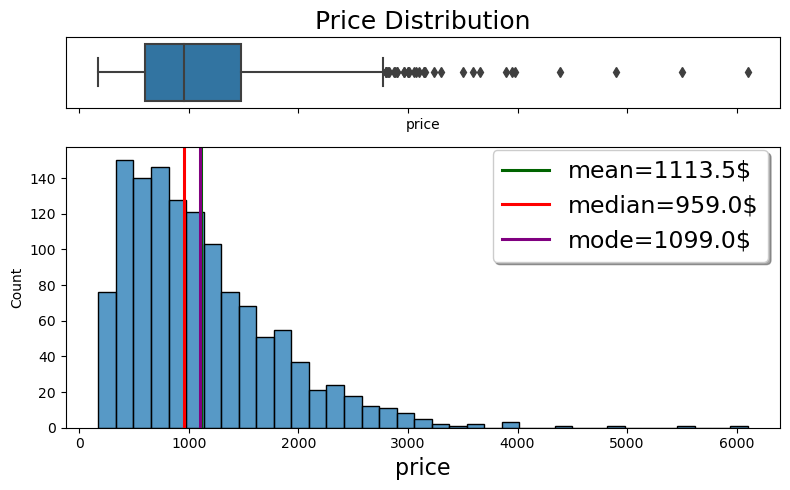

In [84]:
num_plot(df_clean, 'price', 'Price Distribution','$')

There seems to be some laptops with a price over 3000 euros.

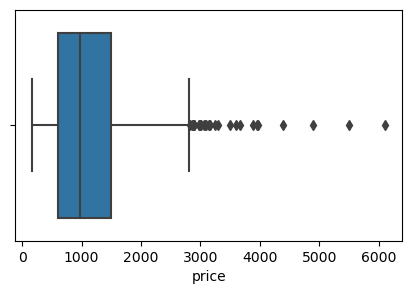

In [85]:
fig, ax  = plt.subplots(figsize=(5,3))
ax=sns.boxplot(x='price', data=df)


<Axes: xlabel='typename', ylabel='price'>

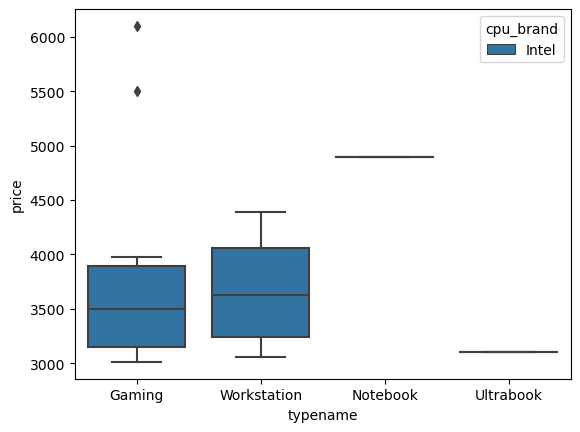

In [86]:
sns.boxplot(x='typename', y='price', data=df[df['price']>3000], hue='cpu_brand')

It looks like most of them are Gaming PCs or Workstations with intel CPU. There is also one Notebook with a price close to 5000 euros and 2 outlier values for Gaming Pc, with a price close to 5500 euros and 6000 euros.

In [87]:
df[df['price']>4500]

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
196,Razer,Blade Pro,Gaming,17.3,Intel Core i7 7820HK,32,Nvidia GeForce GTX 1080,Windows 10,3.49,6099.0,3840x2160,NaN,1.0,2.9,1000.0,SSD,0.0,NaN,Intel,Nvidia
610,Lenovo,Thinkpad P51,Notebook,15.6,Intel Xeon E3-1535M v6,32,Nvidia Quadro M2200M,Windows 10,2.50,4899.0,3840x2160,IPSPanel,0.0,3.1,1000.0,SSD,0.0,NaN,Intel,Nvidia
830,Razer,Blade Pro,Gaming,17.3,Intel Core i7 7820HK,32,Nvidia GeForce GTX 1080,Windows 10,3.49,5499.0,3840x2160,NaN,1.0,2.9,512.0,SSD,0.0,NaN,Intel,Nvidia


### RAM distribution among laptops

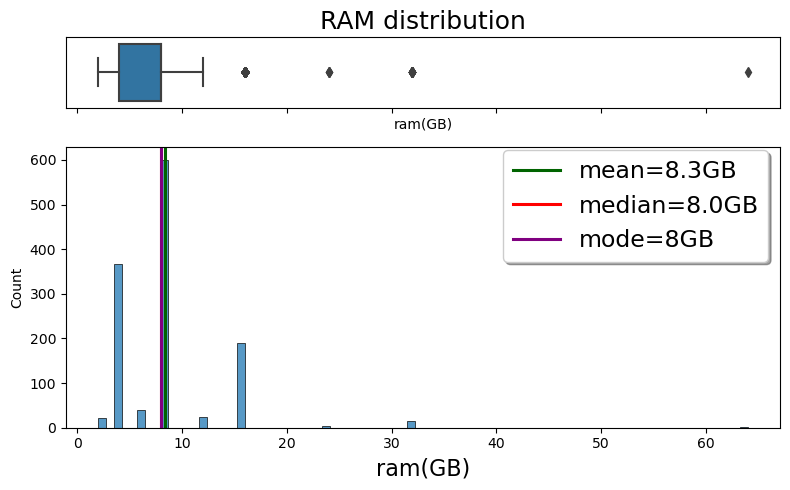

In [88]:
num_plot(df_clean, 'ram(GB)','RAM distribution','GB')

In [89]:
popular_ram_percentage = '{:.2f}'.format(len(df[df['ram(GB)']==8])*100/len(df))
print('Most laptops have 8 GB RAM, which make ' +popular_ram_percentage+ '% of the total laptops.')

Most laptops have 8 GB RAM, which make 47.54% of the total laptops.


### CPU Frequency distribution among laptops

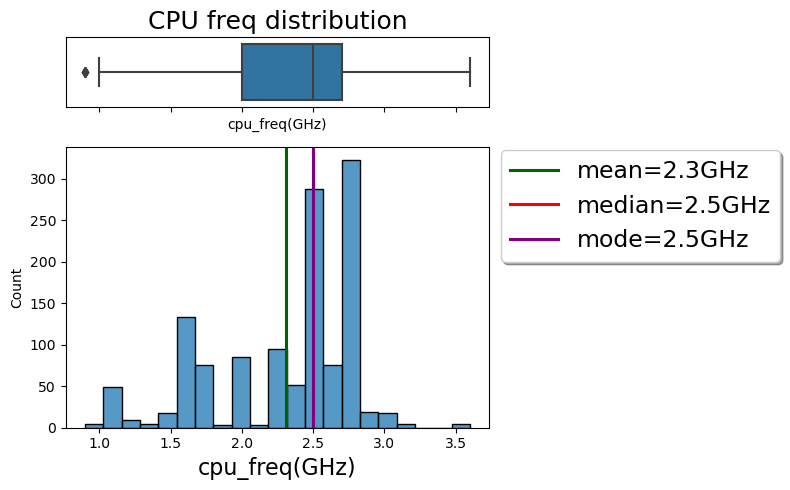

In [90]:
num_plot(df_clean, 'cpu_freq(GHz)','CPU freq distribution','GHz')

In [91]:
popular_cpufreq_percentage = '{:.2f}'.format(len(df[df['cpu_freq(GHz)']==2.5])*100/len(df))
print('Most laptops have 2.5 GHZ CPU, which make ' +popular_cpufreq_percentage+ '% of the total laptops.')

Most laptops have 2.5 GHZ CPU, which make 22.50% of the total laptops.


### Hard Drive capacity distribution among laptops

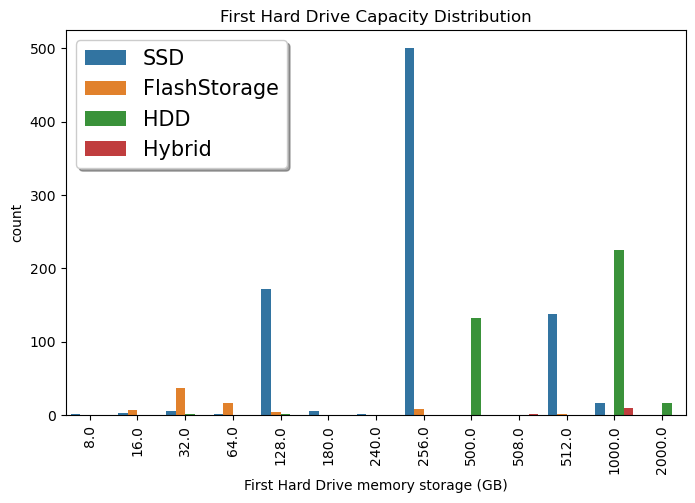

In [92]:
fig, ax  = plt.subplots(figsize=(8,5))
ax=sns.countplot(x='memory_1_sto(GB)', data=df, hue='memory_1_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('First Hard Drive memory storage (GB)')
plt.title('First Hard Drive Capacity Distribution')
plt.legend(loc='upper left', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
plt.show()

Most PCs have 256 GB of storage, which is for the most part SSD. Moreover, for storage of 1 TB or higher, most of them are HDD.

#### Second Hard Drive capacity distribution among laptops

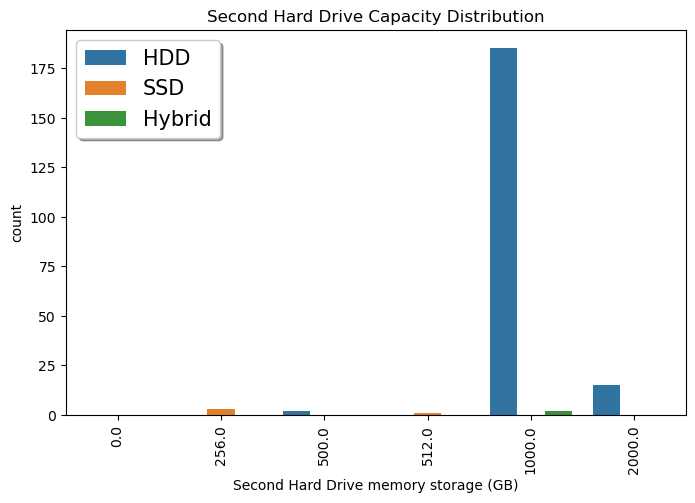

In [93]:
fig, ax  = plt.subplots(figsize=(8,5))
ax=sns.countplot(x='memory_2_sto(GB)', data=df, hue='memory_2_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Second Hard Drive memory storage (GB)')
plt.title('Second Hard Drive Capacity Distribution')
plt.legend(loc='upper left', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
plt.show()

Most of second hard drive storages are 1 TB HDD disks



## 3. Outliers detection

In [94]:
# Writing a custom plot function for linear regression line.
def lr_plot(df, col_x, col_y, leg):
    slope, intercept, r_value, p_value, std_err = stats.linregress(df[col_x],df[col_y])
    sns.regplot(x=col_x, y = col_y, data=df, color='#0d98ba', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
    plt.legend(loc=leg, ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
    plt.title(col_y + ' VS ' + col_x)
    plt.show()

    return slope, intercept

### Price vs RAM

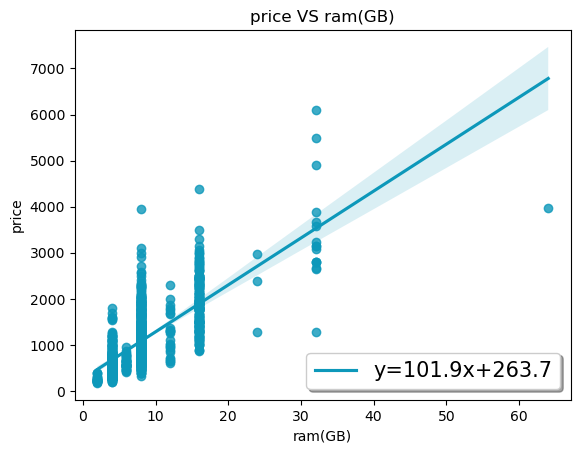

In [95]:
slope, intercept = lr_plot(df_clean,'ram(GB)','price', 'lower right')

We can see an outlier value.

In [96]:
df_clean[df_clean['ram(GB)']>60]

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
1066,Asus,ROG G701VO,Gaming,17.3,Intel Core i7 6820HK,64,Nvidia GeForce GTX 980,Windows 10,3.58,3975.0,1920x1080,IPSPanel,0.0,2.7,1000.0,SSD,0.0,NaN,Intel,Nvidia


In [97]:
df_clean = df_clean[df_clean['ram(GB)']<60]

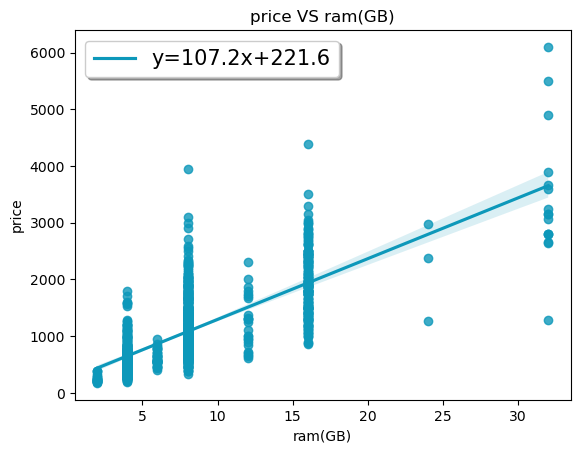

In [98]:
slope, intercept = lr_plot(df_clean,'ram(GB)','price', 'upper left')

### Price vs CPU Frequency

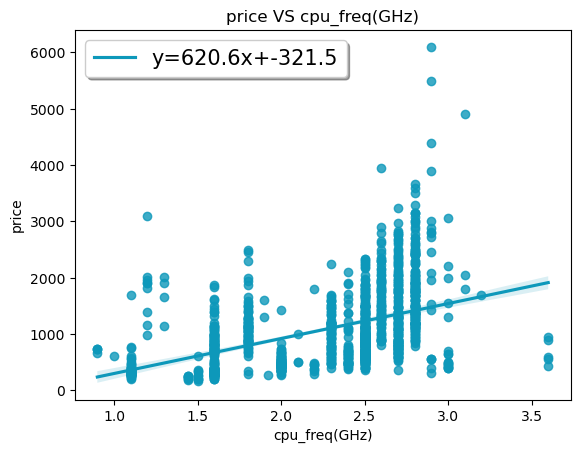

In [99]:
slope, intercept = lr_plot(df_clean,'cpu_freq(GHz)','price', 'upper left')

We can see a positive trend between price and the CPU frequency, with no obvious outliers.

### Price vs Inches

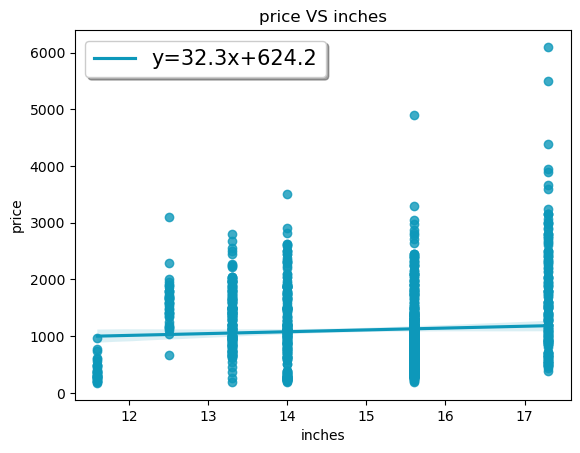

In [100]:
slope, intercept = lr_plot(df_clean,'inches','price', 'upper left')

Since the line is almost flat, it tells us that screen size very slightly affect the price.

### Price vs CPU Brand (Grouped by GPU Brand)

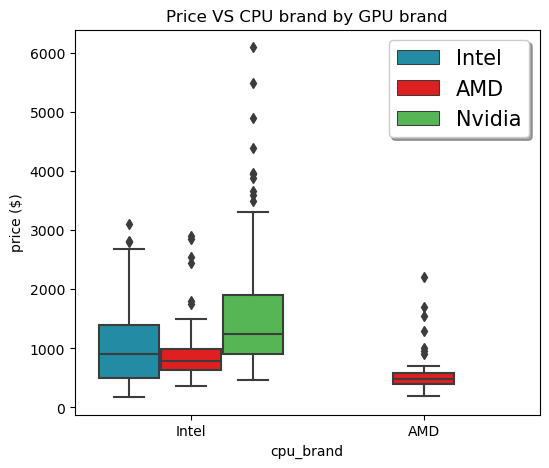

In [101]:
cpu_palette = {'Intel':'#0d98ba', 'AMD':'#FF0000', 'Nvidia':'#46C646'}
fig, ax = plt.subplots(figsize=(6,5))
sns.boxplot(x='cpu_brand', y='price', data=df, hue='gpu_brand', palette=cpu_palette)
ax.set_title('Price vs CPU brand by GPU brand')
plt.ylabel('price ($)')
plt.legend(loc='upper right', ncol=1, fontsize=15, fancybox=True, shadow=True, frameon=True)
plt.title('Price VS CPU brand by GPU brand')
plt.show()

- Laptops with Intel CPUs are more expensive.
- Laptops with an AMD CPUs also have and AMD GPUs
- Laptops with Nvidia GPUs are more expensive.

### Most common GPUs

In [102]:
gpu_list = df_clean['gpu'].value_counts()[:15].index.tolist()

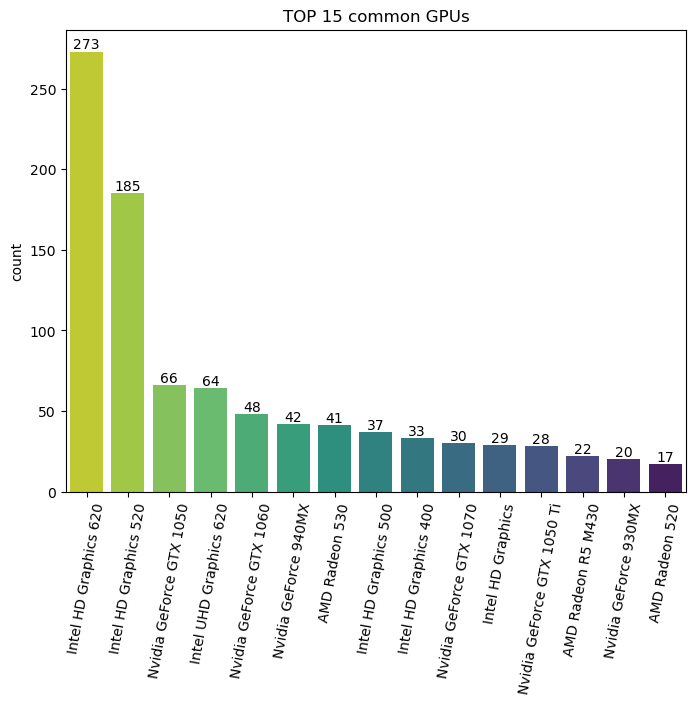

In [103]:
plt.figure(figsize=(8,6))
ax=sns.countplot(x='gpu', data=df_clean[df_clean['gpu'].isin(gpu_list)], order = gpu_list, palette='viridis_r')
plt.xticks(rotation=80);
ax.bar_label(ax.containers[0])
plt.title('TOP 15 common GPUs')
plt.xlabel('')
plt.show()

The 2 most common GPUs are integrated Intel GPUs HD Graphics 620 and 520, while the third one is the Nvidia GTX1050.

### Most common CPUS

In [104]:
cpu_list = df_clean['cpu'].value_counts()[:15].index.tolist()

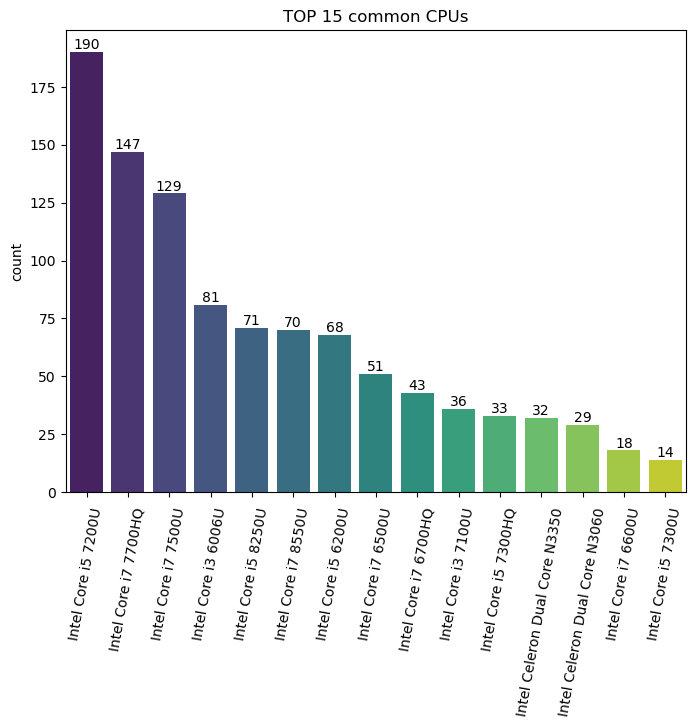

In [105]:
plt.figure(figsize=(8,6))
ax=sns.countplot(x='cpu', data=df_clean[df_clean['cpu'].isin(cpu_list)], order = cpu_list, palette='viridis')
plt.xticks(rotation=80);
ax.bar_label(ax.containers[0])
plt.title('TOP 15 common CPUs')
plt.xlabel('')
plt.show()

All the TOP 15 most common CPUs are from Intel.

### Average price of laptops by company

In [106]:
df['company'].value_counts()

Dell         297
Lenovo       297
HP           274
Asus         158
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        8
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: company, dtype: int64

There are companies with less than 10 laptops in the dataset, which is a very low number from which we can extract statistical results.
For this reason, we will consider only laptops with at least 20 laptops in the dataset.

In [107]:
company_list = df['company'].value_counts().index[:8].tolist()
company_list

['Dell', 'Lenovo', 'HP', 'Asus', 'Acer', 'MSI', 'Toshiba', 'Apple']

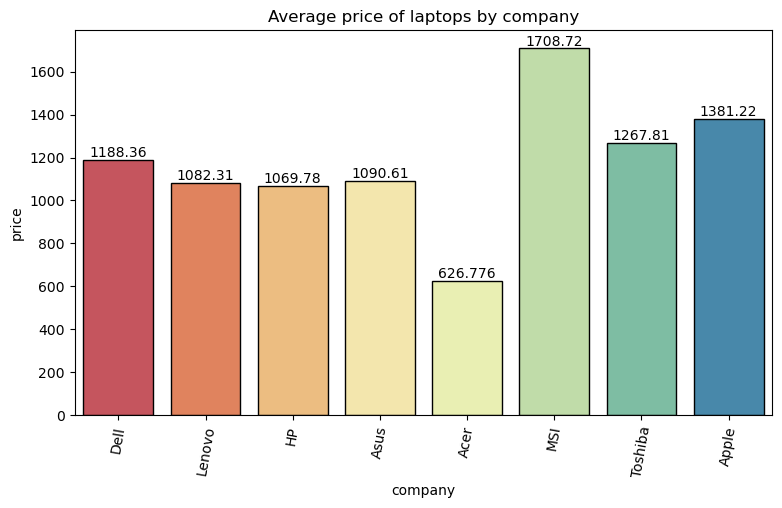

In [108]:
plt.figure(figsize=(9,5))
ax=sns.barplot(x='company', y='price', data=df_clean[df_clean['company'].isin(company_list)],
                order=company_list, 
                palette='Spectral', 
                errorbar=('ci', False),
                edgecolor="black")
plt.xticks(rotation=80);
ax.bar_label(ax.containers[0])
plt.title('Average price of laptops by company')
plt.show()

- MSI laptops are on average the most expensive, with an average price of 1708.72\$.
- Acer are the cheapest, with an average price of 626\$.
- Laptops from Dell, Lenovo, HP and Asus have, on average, a price around 1000\$.

## Correlation Matrix

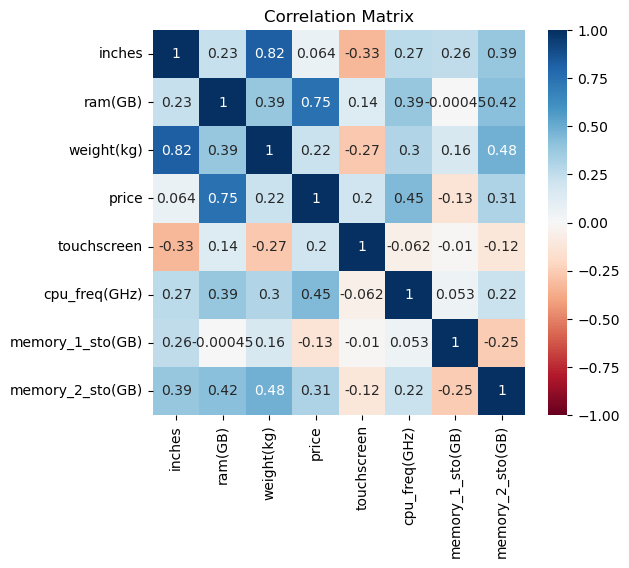

In [109]:
plt.figure(figsize=(6, 5))
sns.heatmap(df_clean.corr(numeric_only=True), cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


- RAM has a high positive correlation with price (+0.75): more expensive laptops tends to have a higher price.
- CPU Freq has a quite moderate positive correlation with the price (+0.45).
- Inches and Weight have a high positive correlation (+0.82) since laptops with bigger screens tend to be heavier.

## 4. Data Preparation for Prediction Model

In [110]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

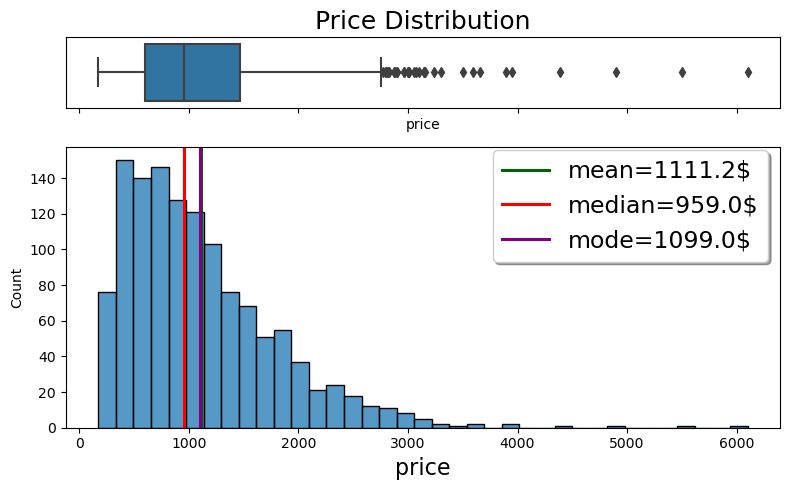

In [111]:
num_plot(df_clean, 'price', 'Price Distribution','$')

In [112]:
df1=df_clean.copy()

Moreover, since the target variable 'price' is right skewed, we will log transform it to improve the prediction performance of the ML algorithm.

In [113]:
df1['price']=np.log(df1['price'])

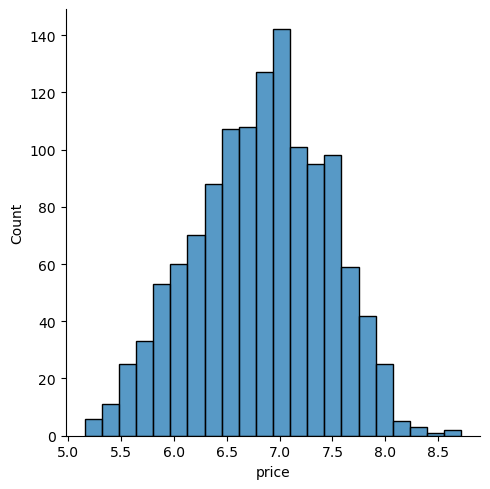

In [114]:
sns.displot(df1['price'])

In [115]:
df1=df1.fillna('NaN')

### Feature Encoding

Defining the categorical columns.

In [116]:
catCols =  ['company','product','typename','cpu','gpu','opsys','resolution',
                    'screentype','resolution','memory_1_type','memory_2_type',
                    'gpu_brand','cpu_brand']

In [117]:
print('For One Hot Encoding')
print('Dataframe Encoded Dimension: '
      , pd.get_dummies(df1, columns=catCols, drop_first=True).shape)

For One Hot Encoding
Dataframe Encoded Dimension:  (1261, 849)


In [118]:
en = LabelEncoder()
for cols in catCols:
    df1[cols] = en.fit_transform(df1[cols])
    
print('For Label Encoding')
print('Dataframe Encoded Dimension: ', df1.shape)

For Label Encoding
Dataframe Encoded Dimension:  (1261, 20)


In [119]:
df1.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,1,295,4,13.3,46,8,52,7,1.37,7.200194,6,1,0.0,2.3,128.0,3,0.0,2,1,1
1,1,296,4,13.3,46,8,45,7,1.34,6.801216,1,2,0.0,1.8,128.0,0,0.0,2,1,1
2,6,49,3,15.6,52,8,47,3,1.86,6.354370,3,2,0.0,2.5,256.0,3,0.0,2,1,1
4,1,295,4,13.3,46,8,53,7,1.37,7.497540,6,1,0.0,3.1,256.0,3,0.0,2,1,1
5,0,57,3,15.6,11,4,13,4,2.10,5.991465,0,2,0.0,3.0,500.0,1,0.0,2,0,0


### Variable Preparation

In [120]:
X=df1.drop('price', axis = 1).values

In [121]:
y=df1['price'].values

### Train - Test split

In [122]:
seed = 100

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = seed)

### Random Forest

In [124]:
from sklearn.ensemble import RandomForestRegressor

In [125]:
rf = RandomForestRegressor(n_estimators=100, max_depth=100, max_features=15)

In [126]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, max_features=15)

In [127]:
y_pred_rf = rf.predict(X_test)

### Model Evaluation & Metrics

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [129]:
mse_rf = mean_squared_error(np.exp(y_test), np.exp(y_pred_rf))
print("RMSE using RF: {} $ ".format(np.round(np.sqrt(mse_rf)),4))

RMSE using RF: 267.0 $ 


In [130]:
print("R2 using Random Forest: {:.2f} %".format(np.round(r2_score(y_test, y_pred_rf),4)*100))

R2 using Random Forest: 90.18 %


In [131]:
mse = mean_squared_error(y_test,y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor")
print("Evaluation Metrics:")
print("Mean Squared Error (MSE): {:.4f}".format(mse))
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("R-squared (R2) Score: {:.4f}".format(r2))


Random Forest Regressor
Evaluation Metrics:
Mean Squared Error (MSE): 0.0395
Mean Absolute Error (MAE): 0.1512
R-squared (R2) Score: 0.9018


### Feature Importance for RandomForest

As we used random forest regressor, we can plot the feature importance determined by the algorithm to perform the regression to better understand what contributes the most to a laptop price.

In [132]:
feature_name_list=df1.drop('price', axis = 1).columns

In [133]:
rf.feature_names = feature_name_list

In [134]:
rf_feat_df= pd.DataFrame({'feature': rf.feature_names,'importance':rf.feature_importances_})

In [135]:
rf_sorted_df=rf_feat_df.sort_values('importance', ascending=False)

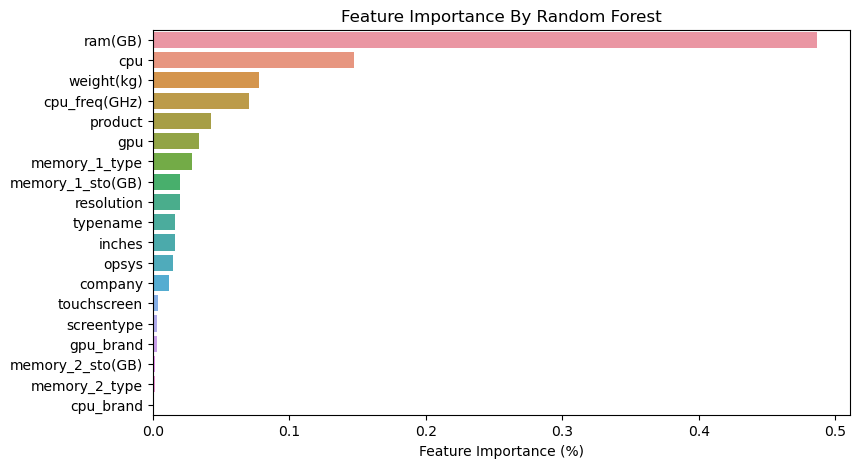

In [136]:
plt.figure(figsize=(9,5))
sns.barplot(x='importance', y='feature', data=rf_sorted_df)
plt.title('Feature Importance By Random Forest')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')
plt.show()

## 5. Alternative Models & Performance Evaluation

In [137]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

In [138]:
regression_models = {
    "lr": LinearRegression(),
    "dt": DecisionTreeRegressor(),
    "gb": GradientBoostingRegressor(),
    "xgb": XGBRegressor()
}

models = {}

y_pred_gb = None
y_pred_xgb = None

for model_name, model in regression_models.items():
    model.fit(X_train, y_train)
    models[model_name] = (model.__class__.__name__, model.predict(X_test))
    
    if model_name == 'gb':
        y_pred_gb = models[model_name][1]
    elif model_name == 'xgb':
        y_pred_xgb = models[model_name][1]

for model_name, (model_fullname, predictions) in models.items():
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"{model_fullname}")
    print("Evaluation Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R2) Score: {r2:.4f}")
    print('------------------------------------------------------------------')
    print()


LinearRegression
Evaluation Metrics:
Mean Squared Error (MSE): 0.0776
Mean Absolute Error (MAE): 0.2212
R-squared (R2) Score: 0.8071
------------------------------------------------------------------

DecisionTreeRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 0.0775
Mean Absolute Error (MAE): 0.2025
R-squared (R2) Score: 0.8072
------------------------------------------------------------------

GradientBoostingRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 0.0376
Mean Absolute Error (MAE): 0.1484
R-squared (R2) Score: 0.9066
------------------------------------------------------------------

XGBRegressor
Evaluation Metrics:
Mean Squared Error (MSE): 0.0357
Mean Absolute Error (MAE): 0.1430
R-squared (R2) Score: 0.9112
------------------------------------------------------------------



## 6. Model Comparison

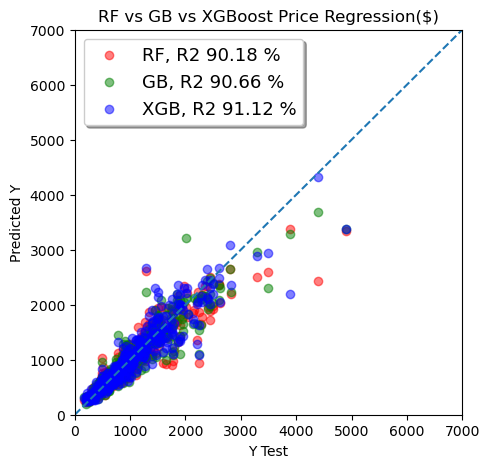

In [139]:
plt.figure(figsize = (5,5))
plt.scatter(np.exp(y_test), np.exp(y_pred_rf), alpha=0.5, color='red',label='RF, R2 {:.2f} %'.format(r2_score(y_test, y_pred_rf)*100))
plt.scatter(np.exp(y_test), np.exp(y_pred_gb), alpha=0.5, color='green',label='GB, R2 {:.2f} %'.format(r2_score(y_test, y_pred_gb)*100))
plt.scatter(np.exp(y_test), np.exp(y_pred_xgb), alpha=0.5, color='blue',label='XGB, R2 {:.2f} %'.format(r2_score(y_test, y_pred_xgb)*100))
plt.plot([0, 7000], [0, 7000], linestyle='--')
plt.axis([0, 7000, 0, 7000])
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('RF vs GB vs XGBoost Price Regression($)')
plt.legend(loc='upper left', ncol=1, fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

In comparison to **Random Forest Regression**, both **Gradient Boosting Regression** and **XGBoost Regression** show improved performance in terms of the evaluation metrics:

**Gradient Boosting Regression:**
The Gradient Boosting Regression model achieves a lower **MSE** and **MAE** compared to Random Forest, indicating reduced prediction errors. Additionally, it has a higher **R-squared score** of **0.9070**, suggesting that the model explains more of the target variable's variance.

**XGBoost Regression:**
The XGBoost Regression model further improves upon the results of Gradient Boosting Regression. It achieves a lower **MSE** and **MAE**, indicating even fewer prediction errors. Additionally, it has the highest **R-squared score** of **0.9112**, suggesting that it explains the most variance in the target variable among the models compared.

In summary, both **Gradient Boosting Regression** and **XGBoost Regression** outperform Random Forest in terms of **MSE**, **MAE**, and **R-squared score**. They provide better predictive performance and capture more of the variance in the target variable, with **XGBoost Regression** achieving the highest accuracy among the three models.


This notebook was created as a part of my ML course I took as a way to learn to implement data preprocessing and model evaluation.

I used this notebook by https://www.kaggle.com/ludovicocuoghi as a guide.

https://www.kaggle.com/code/ludovicocuoghi/xgboost-optuna-deep-feature-engineering-r2-93?kernelSessionId=80791733